In [1]:
import math
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import ElasticNet,Lasso,Ridge,LinearRegression,ElasticNetCV,LassoCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 1. write the equation that governs the SRE
# M - 2M (1 / (1 + exp((a * x)^b)))

In [2]:
def single_sre(a,b,m,cycles):
        try:
            sre = []
            for cycle in cycles:
                z = 1 + math.exp((a * cycle)**b)
                f = m - ((2* m) * (1/z))
                sre.append(f)
            return sre
        except OverflowError:
            z = float('inf')
            return z

In [3]:
def rmse(x,y):
    return np.sqrt(mean_squared_error(x,y))

In [4]:
def r2(actual,predicted):
    df = pd.DataFrame({'actual':actual,'predicted':predicted})
    SS_tot = sum((df['actual']-df['actual'].mean())**2)
    SS_reg = sum((df['actual']-df['predicted'])**2)
    return(1-SS_reg/SS_tot)

In [5]:
def expandgrid(a,b):
    product = list(itertools.product(list(np.ravel(a)),
                                     list(np.ravel(b))))
    df = pd.DataFrame(product,columns=['a','b'])
    return df

# 2. create a range of values for a, b, and m

In [6]:

num_a = 100
num_b = 1
a_range = np.linspace(.02, .03,num_a)
b_range = 0.6
#b_range = seq(.5, .7, length.out = num_b)
m_range = 20.5 # fixed

In [7]:
all_combinations = expandgrid(a_range,b_range)
num_combinations = all_combinations.shape[0]

- estiamted SRE through cell sage: a = 0.0219, b = 0.600, m = 20.5

# 3. Create the data required for regression
- read in the data

In [8]:
cells = pd.read_excel('./cells.xlsx')
response = cells[cells['cell']==4]

- create data required for elastic net as a 
- series of different potential values of a, b, and m

In [9]:
cycles = response['cycles']
capacity = response['capacity']
num_cycles = len(cycles)
pred_matrix = np.zeros((num_cycles,num_combinations))

In [10]:
for i in range(num_combinations):
    pred_matrix[:,i] = single_sre(cycles=cycles,
                                  a=all_combinations['a'][i], 
                                  b=all_combinations['b'][i],
                                  m=m_range)

# 4.  elastic-net regression analysis

In [11]:
enet = ElasticNetCV(l1_ratio=0.5)
fit = enet.fit(X=pred_matrix,y=capacity)

# DOUBT

In [12]:
temp_lambda = fit.alphas_
new_lambda = [math.exp(i) for i in np.linspace(np.log(temp_lambda[1]),np.log(temp_lambda[3]),100)]
enet = ElasticNetCV(l1_ratio=0.5,alphas=new_lambda)
fit = enet.fit(X=pred_matrix,y=capacity)

In [13]:
fit.coef_

array([0.0130011 , 0.01256167, 0.01211493, 0.0116609 , 0.01119958,
       0.01073101, 0.01025522, 0.00977227, 0.00928225, 0.00878523,
       0.00828131, 0.00777062, 0.00725329, 0.00672944, 0.00619924,
       0.00566284, 0.00512043, 0.00457216, 0.00401824, 0.00345882,
       0.00289408, 0.00232419, 0.00174929, 0.00116952, 0.000585  ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [14]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
fit = lm.fit(X=pred_matrix[:,20:21],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[0.99998282]])

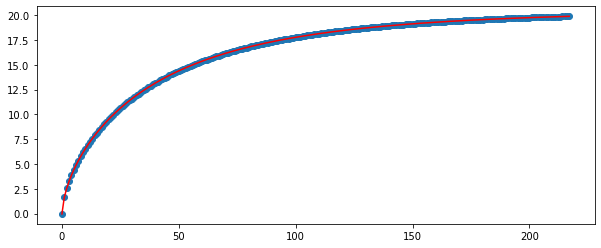

In [17]:
pred_val = fit.predict(pred_matrix[:,20:21])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [18]:
rmse(x=capacity,y=pred_val)

0.005868387797403959

In [19]:
r2(capacity,pred_val.reshape(-1,))

0.9999980747880599

# Adaptive Lasso

In [20]:
enet = ElasticNetCV(l1_ratio=0,alphas=np.arange(0,1,0.2))
fit = enet.fit(pred_matrix,capacity)
temp_coefs = fit.coef_
enet = ElasticNetCV(l1_ratio=1/abs(min(temp_coefs)))
fit = enet.fit(pred_matrix,capacity)

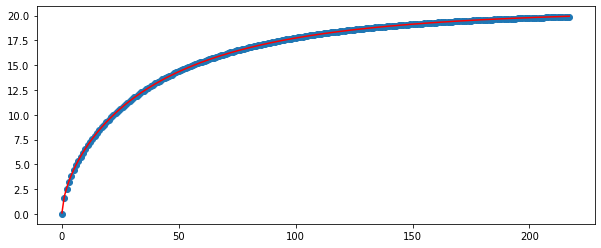

In [21]:
pred_val = fit.predict(pred_matrix)
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [22]:
fit = lm.fit(X=pred_matrix[:,1:2],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[0.9897321]])

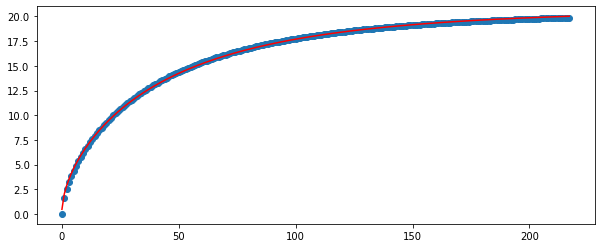

In [23]:
pred_val = fit.predict(pred_matrix[:,1:2])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [24]:
rmse(x=capacity,y=pred_val)

0.10578758199793241

In [25]:
r2(capacity,pred_val.reshape(-1,))

0.9993743804424164

# LASSO

In [26]:
enet = ElasticNetCV(l1_ratio=1)
fit = enet.fit(pred_matrix,capacity)
temp_lambda = fit.alphas_
new_lambda = [math.exp(i) for i in np.linspace(np.log(temp_lambda[1]),np.log(temp_lambda[5]),100)]
enet = ElasticNetCV(l1_ratio=1,alphas=new_lambda)
fit = enet.fit(pred_matrix,capacity)

In [27]:
fit.coef_

array([0.29134624, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [28]:
fit = lm.fit(X=pred_matrix[:,18:19],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[0.99885687]])

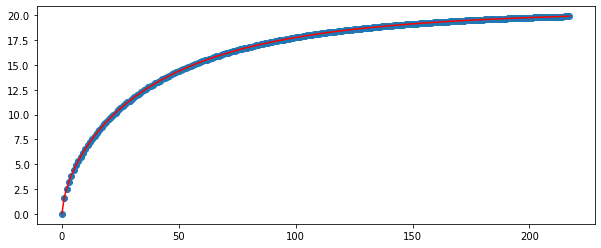

In [29]:
pred_val = fit.predict(pred_matrix[:,18:19])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [30]:
rmse(x=capacity,y=pred_val)

0.005642523882394131

In [31]:
r2(capacity,pred_val.reshape(-1,))

0.9999982201321941

# SCAD

In [32]:
enet= ElasticNetCV(l1_ratio=3.7)
fit = enet.fit(pred_matrix,capacity)
fit.coef_

array([7.94639756e-01, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

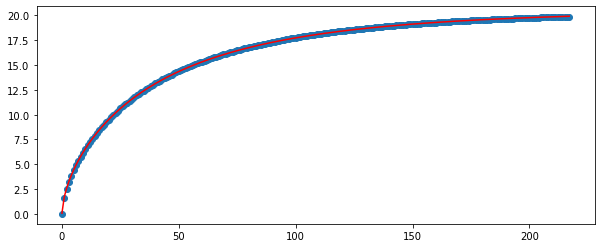

In [33]:
pred_val = fit.predict(pred_matrix)
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
# plt.ylim(,20)
plt.show()

In [34]:
rmse(x=capacity,y=pred_val)

0.022192855650984184

In [35]:
r2(capacity,pred_val.reshape(-1,))

0.9999724661265152

In [36]:
fit = lm.fit(X=pred_matrix[:,12:13],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[0.99553902]])

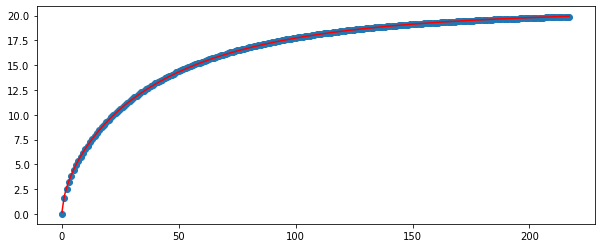

In [37]:
pred_val = fit.predict(pred_matrix[:,12:13])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
plt.show()

In [38]:
rmse(x=capacity,y=pred_val)

0.04051436332717368

In [39]:
r2(capacity,pred_val.reshape(-1,))

0.9999082388235927

In [40]:
fit = lm.fit(X=pred_matrix[:,30:31],y=np.array(capacity).reshape(-1,1))
fit.coef_

array([[1.0057404]])

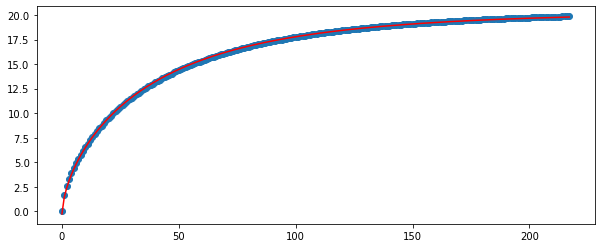

In [41]:
pred_val = fit.predict(pred_matrix[:,30:31])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(capacity))),y=capacity)
plt.plot(pred_val,'r')
plt.show()

In [42]:
rmse(x=capacity,y=pred_val)

0.06258786372986938

In [43]:
r2(capacity,pred_val.reshape(-1,))

0.9997810115586947

# Fused Lasso

In [44]:
# library(genlasso)
# fit = fusedlasso2d(capacity, pred_matrix, 10, 10)
# plot(fit$beta[, 50])
# which(fit$beta[,50] > .02)

# SRE Solve

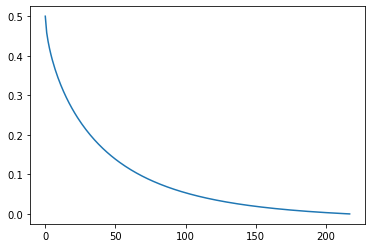

In [45]:
# normalized capacity

norm_capacity = capacity
m = max(norm_capacity)
norm_capacity =( norm_capacity - m )/ (- 2 * m)
plt.plot(norm_capacity)
plt.show()

In [46]:
b_range = np.linspace(0.4,0.7,100)
b_matrix = np.zeros([len(response['cycles']),len(b_range)])
for i in range(len(b_range)):
    b_matrix[:,i] = response['cycles']*b_range[i]

In [47]:
enet = ElasticNetCV(l1_ratio=0.5)
fit = enet.fit(b_matrix,norm_capacity)

fit.intercept_

0.24799004306357647

In [48]:
fit.coef_

array([-3.91313335e-04, -2.33409369e-05, -2.02104492e-05, -1.97592565e-05,
       -1.93255059e-05, -1.89043628e-05, -1.84953683e-05, -1.80980876e-05,
       -1.77121042e-05, -1.73370195e-05, -1.69724515e-05, -1.66180340e-05,
       -1.62734164e-05, -1.59382622e-05, -1.56122487e-05, -1.52950665e-05,
       -1.49864185e-05, -1.46860196e-05, -1.43935961e-05, -1.41088850e-05,
       -1.38316337e-05, -1.35615995e-05, -1.32985490e-05, -1.30422580e-05,
       -1.27925107e-05, -1.25490996e-05, -1.23118250e-05, -1.20804947e-05,
       -1.18549238e-05, -1.16349341e-05, -1.14203541e-05, -1.12110184e-05,
       -1.10067679e-05, -1.08074490e-05, -1.06129139e-05, -1.04230198e-05,
       -1.02376292e-05, -1.00566093e-05, -9.87983218e-06, -9.70717414e-06,
       -9.53851594e-06, -9.37374243e-06, -9.21274239e-06, -9.05540842e-06,
       -8.90163676e-06, -8.75132716e-06, -8.60438273e-06, -8.46070982e-06,
       -8.32021788e-06, -8.18281937e-06, -8.04842961e-06, -7.91696670e-06,
       -7.78835137e-06, -

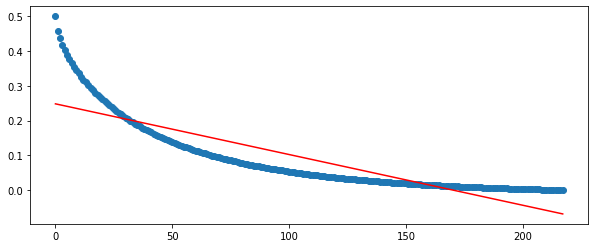

In [49]:
X = b_matrix[:,95]-1
X = pd.DataFrame(X,columns=['b_matrix'])
X['norm_capacity'] = norm_capacity
fit = smf.glm(formula='norm_capacity~b_matrix',data=X).fit()
pred_val = fit.predict(X['b_matrix'])
plt.figure(figsize=(10,4))
plt.scatter(x=list(range(len(norm_capacity))),y=norm_capacity)
plt.plot(pred_val,'r')
plt.show()